$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\renewcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\abs}[1]{\left\lvert#1\right\rvert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\Tr}[0]{^\top}
\newcommand{\grad}[0]{\nabla}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\Var}[1]{\mathrm{Var}\left[#1\right]}
\newcommand{\ip}[3]{\left<#1,#2\right>_{#3}}
\newcommand{\given}[0]{\middle\vert}
\newcommand{\DKL}[2]{\cset{D}_{\text{KL}}\left(#1\,\Vert\, #2\right)}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\DeclareMathOperator*{\trace}{trace}
\newcommand{\1}[1]{\mathbb{I}\left\{#1\right\}}
\newcommand{\setof}[1]{\left\{#1\right\}}
\newcommand{\DO}[1]{\mathrm{do}\left(#1\right)}
\newcommand{\indep}{\perp \!\!\! \perp}
$$


# <center>Causal Inference 097400, Winter 2019-20<br><br>Final Project</center>

#### <center>Aviv Rosenberg<br>`avivr@cs`</center>

##### <center>April, 2020<br></center>


In [1]:
%load_ext autoreload
%autoreload 2

import os
import math
import numpy as np
import pandas as pd

PHYSIONET_DB = 'data/physionet/crisdb'
MHRV_DATA_FILE = 'data/crisdb-full-60min.xlsx'
OUT_DIR = 'out/'

os.makedirs(OUT_DIR, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
plt.rcParams['font.size'] = 12

## Part 1: Creating the datasets

In [3]:
from proj import data
from proj import ci

Load metadata from the PhysioNet CASTRR database files.

In [4]:
df_meta = data.castrr_load_metadata(PHYSIONET_DB)
df_meta.head()

,AGE,SEX
rec,,
e001a,60,Male
e001b,60,Male
e002a,65,Male
e002b,65,Male
e003a,55,Male


Load the HRV features calculated on this database with `mhrv`.
Then, join the HRV features with the metadata.

In [5]:
MHRV_GROUP_NAMES = ['E_CONTROL', 'E_TREATED', 'F_CONTROL', 'F_TREATED', 'M_CONTROL', 'M_TREATED']
dfs = data.load_mhrv_xls(MHRV_DATA_FILE, sheet_names=MHRV_GROUP_NAMES, df_meta=df_meta)

for name, df in dfs.items():
    assert not np.any(pd.isna(df)), name

Loaded E_CONTROL: 5937 samples, 49 features
Loaded E_TREATED: 6018 samples, 49 features
Loaded F_CONTROL: 4617 samples, 49 features
Loaded F_TREATED: 4760 samples, 49 features
Loaded M_CONTROL: 6137 samples, 49 features
Loaded M_TREATED: 6337 samples, 49 features


In [6]:
dfs['E_CONTROL']

RR    NN        AVNN       SDNN      RMSSD     pNN50       SEM  \
rec   win                                                                     
e001a 1    4327  4264  701.071106  41.581642  13.757771  0.234577  0.636785   
      2    4477  4404  750.743286  49.516403  15.641404  0.408812  0.746149   
      3    4722  4650  722.733521  59.652050  14.098043  0.150570  0.874780   
      4    4769  4696  703.978455  53.346508  13.653588  0.255591  0.778470   
      5    4986  4922  687.711121  47.553204  12.772495  0.386100  0.677812   
...         ...   ...         ...        ...        ...       ...       ...   
e286a 16   4840  4819  739.530396  29.074734  10.354865  0.020755  0.418830   
      17   5289  5213  666.909973  41.037853  10.034287  0.095932  0.568383   
      18   5374  5355  667.397583  23.006018  11.370922  0.261487  0.314385   
      19   4924  4856  719.261597  22.993504  10.629254  0.082389  0.329963   
      20   5130  4992  681.668823  20.523258  11.011402  0.080144  0.290475   

            BETA_AR  HF_NORM_AR  HF_PEAK_AR  ...     MSE17     MSE18  \
rec   win                                    ...                       
e001a 1   -1.117969    7.328302    0.327401  ...  1.348242  1.395579   
      2   -1.128235    5.956380    0.254147  ...  1.307543  1.354694   
      3   -1.095494    6.322984    0.252652  ...  1.222841  1.239768   
      4   -1.121374    4.156405    0.255642  ...  1.251534  1.125110   
      5   -1.179842    4.143440    0.240692  ...  1.444636  1.419865   
...             ...         ...         ...  ...       ...       ...   
e286a 16  -0.414241    5.571465    0.346089  ...  1.133445  1.180290   
      17  -0.682378    7.548707    0.325159  ...  0.673941  0.681831   
      18  -1.036899   12.584630    0.319926  ...  0.906764  0.942591   
      19  -0.436453    9.975235    0.269097  ...  1.371525  1.503135   
      20  -0.862907   14.472836    0.387948  ...  1.178824  1.134544   

              MSE19     MSE20        PIP      IALS        PSS        PAS  AGE  \
rec   win                                                                       
e001a 1    1.477925  1.502828  30.816135  0.308468  19.723265   6.191370   60   
      2    1.323236  1.371318  34.196186  0.342267  25.272480   8.969119   60   
      3    1.133098  1.205776  30.537634  0.305657  20.021505   7.118279   60   
      4    1.228755  1.128171  31.856899  0.318850  21.869677   6.984668   60   
      5    1.398180  1.431729  28.728159  0.287543  18.468102   5.099553   60   
...             ...       ...        ...       ...        ...        ...  ...   
e286a 16   1.206903  1.167605  38.659473  0.386883  29.196928  15.646399   65   
      17   0.705784  0.639730  40.053711  0.400806  29.100327  15.288701   65   
      18   0.936589  1.025636  42.689075  0.427157  33.053223  18.169935   65   
      19   1.390089  1.548041  38.632618  0.386612  28.644976  14.229818   65   
      20   1.174832  1.112965  41.646633  0.416750  31.951122  16.326122   65   

              SEX  
rec   win          
e001a 1      Male  
      2      Male  
      3      Male  
      4      Male  
      5      Male  
...           ...  
e286a 16   Female  
      17   Female  
      18   Female  
      19   Female  
      20   Female  

[5937 rows x 49 columns]

Now we'll add the outcome columns. We'll use the non-linear HRV features as the outcomes, which measure the type of dynamics found in the heart beat intervals.

Note that for the treated group, the outcomes must come from the post-treatment data.
However, we'll take the pre-treatment HRV features for the treated group.

In [7]:
SEED = 42

In [8]:
datasets = {}
for drug in ['E', 'F', 'M']:
    df_ci = data.castrr_ci_dataset(
        dfs[f'{drug}_CONTROL'], dfs[f'{drug}_TREATED'],
        ignore_features=['SampEn'],
        include_counterfactuals=False,
        outcome_mse=True, outcome_dfa=True, outcome_beta=True,
        random_seed=SEED
    )
    df_ci.to_csv(f'{OUT_DIR}/df_ci_{drug}.csv')
    assert not np.any(pd.isna(df_ci))
    datasets[drug] = df_ci
    
outcome_columns = [c for c in datasets['E'].columns if c.startswith('Y_')]

In [9]:
for name, df in datasets.items():
    print(f'*** {name} dataset: ', end='')
    X, y, t = data.split_dataset(df, scale_covariates=True)
    print(f'X{X.shape}, y{y.shape}, t{t.shape}')

*** E dataset: X(5274, 25), y(5274, 5), t(5274,)
*** F dataset: X(4119, 25), y(4119, 5), t(4119,)
*** M dataset: X(5621, 25), y(5621, 5), t(5621,)


In [11]:
outcome_columns

['Y_MSE_LO', 'Y_MSE_HI', 'Y_ALPHA1', 'Y_ALPHA2', 'Y_BETA']

### Exploring the data

Let's plot the distribution of the data in the outcome variables of interest, conditioned on the treatment.

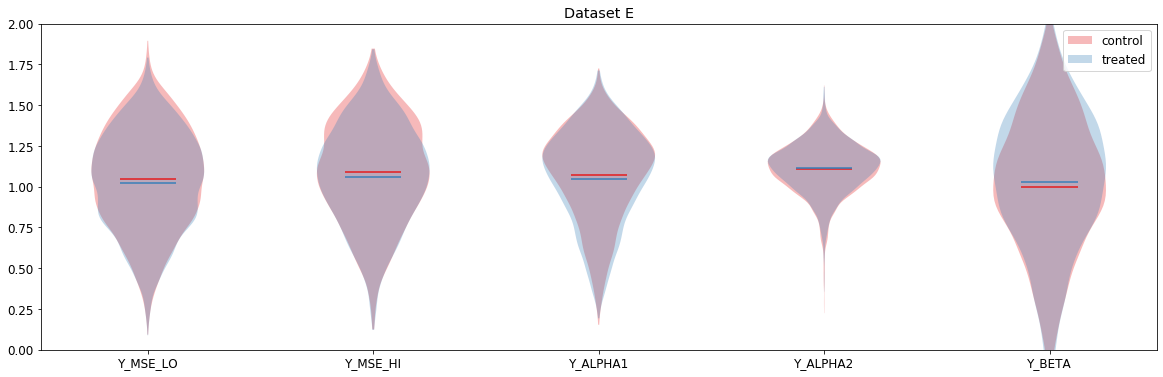

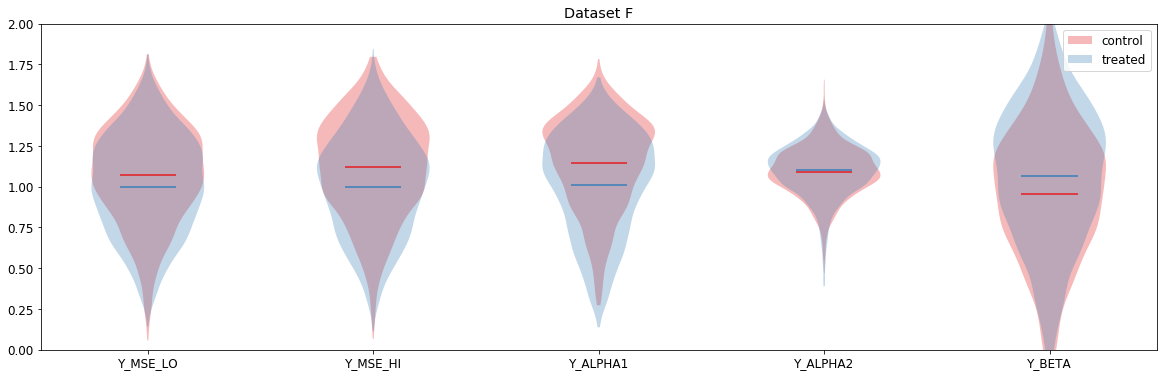

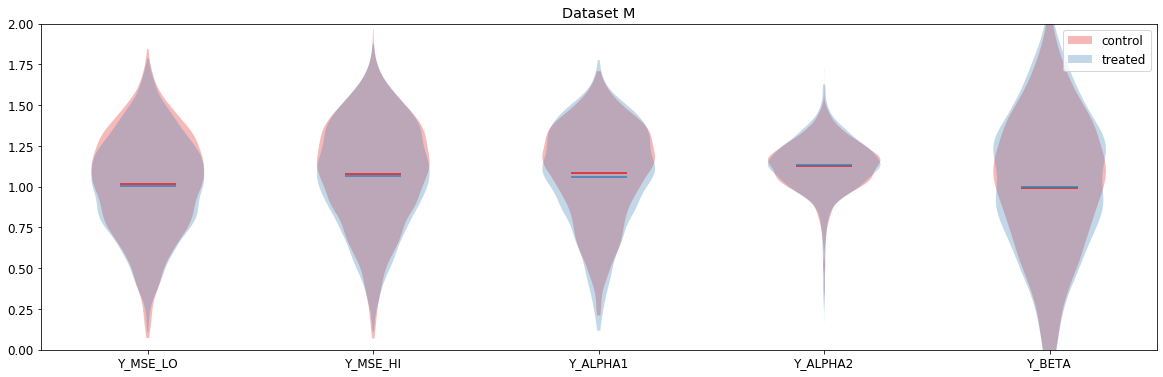

In [12]:
from proj import plot

for i, (name, df) in enumerate(datasets.items()):
    fig, ax = plt.subplots(1, 1, figsize=(20,6))
    group_by = dict(by='T')
    group_legend_names={0: 'control', 1: 'treated'}
    violin_args = dict(showextrema=False, showmeans=True, widths=0.5)
    plot.df_group_violins(ax, df, outcome_columns, group_by, violin_args, group_legend_names)
    ax.set_title(f'Dataset {name}')
    ax.set_ylim(0, 2)

Due to the nature of this dataset, we can compute the real treatment effect since we have counterfactual outcomes.

In [54]:
datasets_cf = {}
for drug in ['E', 'F', 'M']:
    datasets_cf[drug] = data.castrr_ci_dataset(
        dfs[f'{drug}_CONTROL'], dfs[f'{drug}_TREATED'], ignore_features=['SampEn'],
        include_counterfactuals=True, random_seed=None
    )

ate_cols = [r'$\widehat{ATE}$', r'$ATE$', '% Error']
df_ate = pd.DataFrame(columns=pd.MultiIndex.from_product([datasets.keys(), ate_cols]))

for name, ds in datasets_cf.items():
    outcomes = [c for c in ds.columns if c.startswith('Y_') and not c.endswith('_CF')]
    outcomes_cf = [c for c in ds.columns if c.startswith('Y_') and c.endswith('_CF')]
    groups = ds.groupby('T')
    
    n_control = len(groups.get_group(0))
    n_treated = len(groups.get_group(1))
    n_total = n_control + n_treated
    
    # Naive ATE: Avg. outcome in treated group minus avg. outcom in control group.
    # This assumes random treatment assignment
    mean_outcome = groups[outcomes].mean()
    ate_est = mean_outcome.loc[1] - mean_outcome.loc[0]
    
    # Ground-truth treatement effect: Mean treated outcome of all subject minus
    # mean untreated of all subjects.
    mean_outcome_cf = groups[outcomes_cf].mean()
    mean_outcome_cf.columns = mean_outcome.columns
    ate_real = (1/n_total) * (
        (n_treated * mean_outcome.loc[1] + n_control * mean_outcome_cf.loc[0])
        -
        (n_treated * mean_outcome_cf.loc[1] + n_control * mean_outcome.loc[0])
    )
    
    df_ate[(name, ate_cols[0])] = ate_est
    df_ate[(name, ate_cols[1])] = ate_real
    df_ate[(name, ate_cols[2])] = np.abs(ate_real-ate_est) / np.abs(ate_real) * 100
    
df_ate

E                                    F            \
         $\widehat{ATE}$     $ATE$    % Error $\widehat{ATE}$     $ATE$   
Y_MSE_LO       -0.066868 -0.056554  18.236618       -0.081451 -0.071134   
Y_MSE_HI       -0.089082 -0.071586  24.440081       -0.105161 -0.101154   
Y_ALPHA1       -0.061461 -0.050009  22.899115       -0.109631 -0.085708   
Y_ALPHA2        0.022654  0.013562  67.038033        0.025450  0.019561   
Y_BETA          0.090614  0.055224  64.083611        0.109738  0.089532   

                                  M                       
            % Error $\widehat{ATE}$     $ATE$    % Error  
Y_MSE_LO  14.504017       -0.005978 -0.033982  82.407394  
Y_MSE_HI   3.961892       -0.008209 -0.033310  75.356964  
Y_ALPHA1  27.911373       -0.004685 -0.026287  82.178307  
Y_ALPHA2  30.110556        0.029245  0.016485  77.398560  
Y_BETA    22.568552        0.016654  0.031466  47.073940

Can we actually predict outcome from covariates in this dataset?

In [14]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from scipy import stats

from proj.ci.cv import CVConfig, LogSpaceSampler, MLPHiddenLayerSampler

# Define the methods and CV search space for propensity estimation
rcv_config = dict(
    ridge=CVConfig(
        model=Ridge(max_iter=2000, fit_intercept=True),
        params=dict(alpha=LogSpaceSampler(-2, 1))
    ),
    
    lasso=CVConfig(
        model=Lasso(max_iter=2000,tol=0.001, fit_intercept=True),
        params=dict(alpha=LogSpaceSampler(-2, 1))),
    
#     mlp=CVConfig(
#         model=MLPRegressor(solver='lbfgs', max_iter=300),
#         params=dict(
#             hidden_layer_sizes=MLPHiddenLayerSampler(2, 100),
#             activation=['logistic', 'tanh', 'relu'],
#             alpha=LogSpaceSampler(-2, 1),
#         )),
    
#     gbm=CVConfig(
#         model=RegressorChain(GradientBoostingRegressor()),
#         params=dict(
#             base_estimator__n_estimators=stats.randint(1, 50+1),
#             base_estimator__max_depth=stats.randint(1, 3+1),
#             base_estimator__learning_rate=LogSpaceSampler(-2, 0.5),
#         )),
)

In [15]:
from proj.ci.cv import run_cv_config
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.preprocessing import PolynomialFeatures

midx_rows = pd.MultiIndex.from_product([datasets.keys(), rcv_config.keys()], names=['dataset', 'method'])
midx_cols = pd.MultiIndex.from_product([outcome_columns, ('train', 'test')], names=['outcome', 'split'])
df_pred_score = pd.DataFrame(index=midx_rows, columns=midx_cols)

for method, cv_cfg in rcv_config.items():
    
    for i, (name, df) in enumerate(datasets.items()):
        # Get covariates X and treatment assignment t as numpy arrays
        X, y, t = data.split_dataset(df, scale_covariates=True)
        
        # Add feature-feature interactions
        poly_tf = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
        X = poly_tf.fit_transform(X)
        
        # Train a model to estimate propensity using current method,
        # calibrate with two approaches and generate a calibration plot
        model, idx_train, idx_test = \
            run_cv_config(cv_cfg, X, y,
                          stratify=t, test_size=0.3, cv_splits=2, n_iter=25,
                          scorer=make_scorer(mean_absolute_error, greater_is_better=False)
            )
        
        mse_train = mean_absolute_error(y[idx_train], model.predict(X[idx_train]), multioutput='raw_values')
        mse_test = mean_absolute_error(y[idx_test], model.predict(X[idx_test]), multioutput='raw_values')
        print(f'dataset={name}, method={method}, best_params={model.best_params_}')
        
        df_pred_score.loc[(name, method), pd.IndexSlice[:, 'train']] = mse_train
        df_pred_score.loc[(name, method), pd.IndexSlice[:, 'test']] = mse_test
#         y_pred = model.best_estimator_.fit(X, y).predict(X)
#         mae_full = mean_absolute_error(y, y_pred, multioutput='raw_values')
#         df_pred_score.loc[(name, method), pd.IndexSlice[:, 'full']] = mae_full
        
df_pred_score

dataset=E, method=ridge, best_params={'model__alpha': 9.569876770371975}
dataset=F, method=ridge, best_params={'model__alpha': 9.663963029136992}
dataset=M, method=ridge, best_params={'model__alpha': 8.711648261577581}
dataset=E, method=lasso, best_params={'model__alpha': 0.013163709195020525}
dataset=F, method=lasso, best_params={'model__alpha': 0.022905526189440126}
dataset=M, method=lasso, best_params={'model__alpha': 0.016028512156935754}


outcome         Y_MSE_LO            Y_MSE_HI            Y_ALPHA1            \
split              train      test     train      test     train      test   
dataset method                                                               
E       ridge   0.180803  0.196549  0.197764   0.21482  0.126376  0.136478   
        lasso   0.211039  0.223788  0.224645  0.237501  0.145358  0.152652   
F       ridge   0.180863  0.200224   0.19681   0.21915  0.127275  0.142348   
        lasso   0.217181  0.223877  0.236357  0.238506  0.160572  0.164276   
M       ridge   0.185493  0.197364  0.203964  0.221814   0.13517  0.137931   
        lasso   0.216213   0.21781  0.236337  0.232955  0.159756  0.161041   

outcome          Y_ALPHA2               Y_BETA            
split               train       test     train      test  
dataset method                                            
E       ridge   0.0817226  0.0878053  0.262177  0.286156  
        lasso   0.0947656   0.098333  0.286939  0.297212  
F       ridge   0.0823468  0.0877588  0.259362  0.279069  
        lasso    0.100616  0.0983479  0.294679  0.293094  
M       ridge   0.0861849  0.0929566  0.280618  0.299981  
        lasso    0.101456  0.0991142  0.307097  0.307546

## Part 2: Propensiy estimation and common support

The *propensity score* is defined as $e(\vec{x}):=\Pr{\left(\rvar{T}=1\given \rvec{X}=\vec{x}\right)}$.
In other words, it is the probability that a treatment $\rvar{T}=1$ will be assigned to a
unit with covariates $\rvec{X}=\vec{x}$.
In this case, since our treatment variable is age, it is not really "assigned" based on covariates.
However, the propensity estimation can shed light on whether covariates have predictive power regarding age, and help us achieve balanced covariate marginal distributions for matching.

We would like to obtain an estimator for the propensity score, $\hat e(\vec{x})$, from the data.
One important aspect of this estimator is that we would like it to be *calibrated*.
Briefly, this means that for if for example we look at all units $\vec{x}$ such that $e(\vec{x})=0.8$, we expect 80\% of them to actually belong to the treatment group ($\rvar{T}=1$).

In [16]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from scipy import stats

from proj.ci.cv import CVConfig, LogSpaceSampler

# Define the methods and CV search space for propensity estimation
rcv_config = {
    'logistic': CVConfig(
        model=LogisticRegression(dual=False, solver='liblinear', max_iter=200),
        params=dict(C=LogSpaceSampler(-5, 1), penalty=['l1','l2']),
    ),
    'gbm': CVConfig(
        model=GradientBoostingClassifier(),
        params=dict(
            n_estimators=stats.randint(1, 10 + 1),
            max_depth=stats.randint(1, 2 + 1),
            learning_rate=LogSpaceSampler(-2, 0.5),
        )
    ),
}

E logistic 	best_params={'model__C': 6.958780103230353, 'model__penalty': 'l1'}
F logistic 	best_params={'model__C': 0.6179495736681844, 'model__penalty': 'l2'}
M logistic 	best_params={'model__C': 8.048300806495652, 'model__penalty': 'l1'}
E gbm 	best_params={'model__learning_rate': 0.31242799879508953, 'model__max_depth': 2, 'model__n_estimators': 8}
F gbm 	best_params={'model__learning_rate': 1.1492066928873486, 'model__max_depth': 2, 'model__n_estimators': 9}
M gbm 	best_params={'model__learning_rate': 0.6533479705456409, 'model__max_depth': 2, 'model__n_estimators': 9}


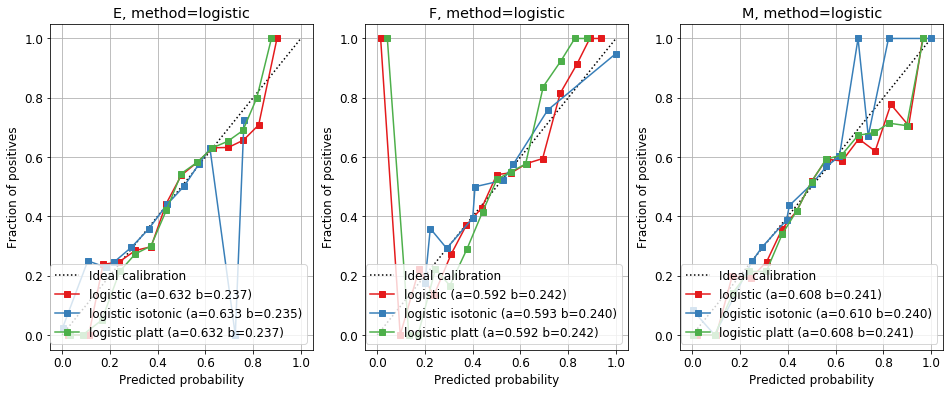

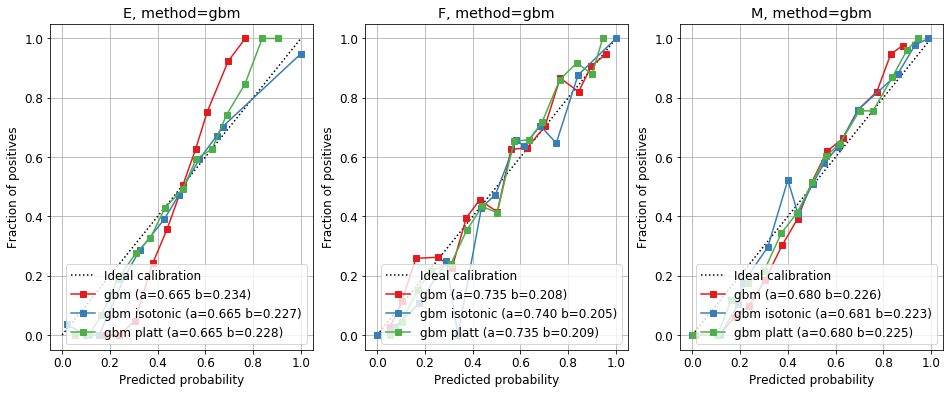

In [17]:
from proj.ci.propensity import fit_propensity_cv

# A dict to store propensities from each dataset and each method
dataset_propensities = {}

for method, cv_cfg in rcv_config.items():
    fig, ax = plt.subplots(nrows=1, ncols=len(datasets), figsize=(16, 6))
    
    for i, (dataset_name, df) in enumerate(datasets.items()):
        # Get covariates X and treatment assignment t as numpy arrays
        X, _, t = data.split_dataset(df, scale_covariates=True)
        
        # Train a model to estimate propensity using current method,
        # calibrate with two approaches and generate a calibration plot
        model, best_params = fit_propensity_cv(
            cv_cfg, X, t, plot_args=dict(name=method, ax=ax[i]),
            test_size=0.3, n_iter=42, random_state=42+i, cv_splits=4
        )
        
        # Use the best calibrated model (lowest Brier score) to estimate the propensities
        prop = model.predict_proba(X)[:, 1]
        dataset_propensities[(dataset_name, method)] = prop
        
        ax[i].set_title(f'{dataset_name}, method={method}')
        print(f'{dataset_name} {method} \tbest_params={best_params}')

The plots above show the calibration curves of the logistic regression (top row) and the GBM models (middle row).
The ideal calibration is shown as a dotted line.
For each classifier, two calibration methods, Platt and Isotonic Regression, are shown.
In the legend, both the ROC-AUC score (`a`) and the Brier score (`b`) are reported as measures of the model's
classification performance (higher is better) and de-calibration level (lower is better), respectively.

To visualize the propensity estimation results of each method, we can plot the distribution of propensity scores between treated and control groups.

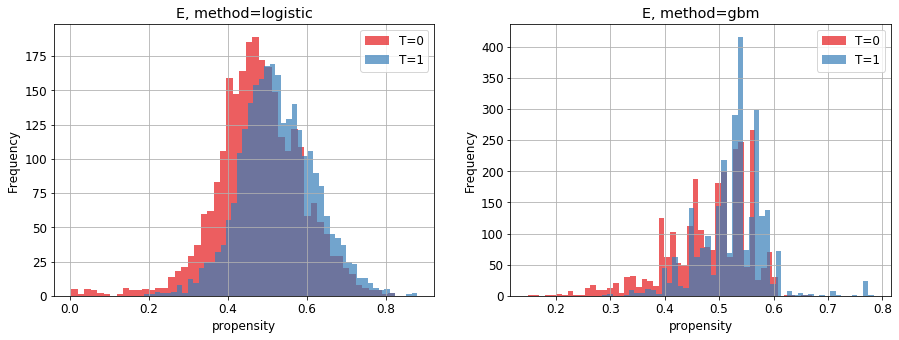

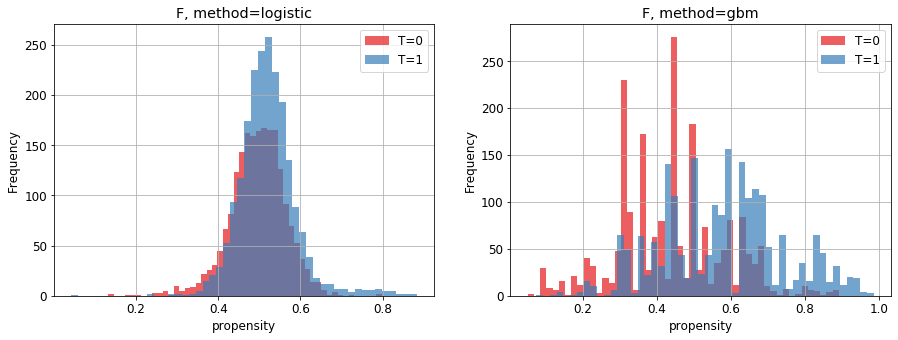

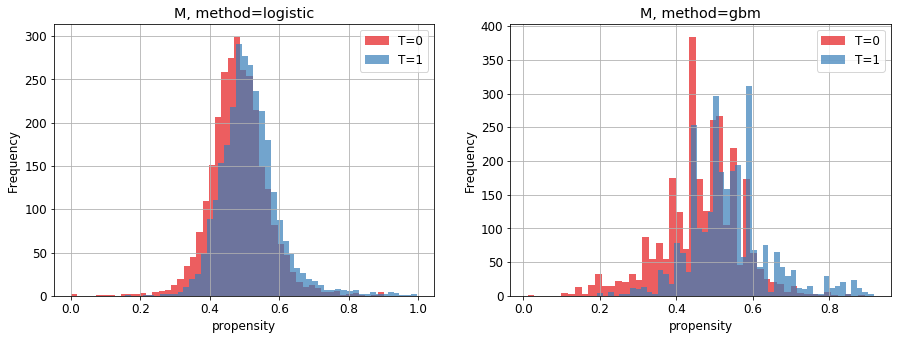

In [18]:
for i, (dataset_name, df) in enumerate(datasets.items()):
    fig, ax = plt.subplots(nrows=1, ncols=len(rcv_config.keys()), figsize=(15, 5))
    # Create a temporaty dataframe
    df_tmp = df.copy()
    
    for j, method in enumerate(rcv_config.keys()):
        # Add propensity from current method to the temporary dataframe
        df_tmp['propensity'] = dataset_propensities[(dataset_name, method)]
        # Plot propensity scores conditioned on treatment
        groups = df_tmp.groupby('T')
        groups['propensity'].plot(kind='hist', sharex=True, alpha=0.7, bins=50, ax=ax[j])
        ax[j].set_title(f'{dataset_name}, method={method}')
        ax[j].set_xlabel('propensity'); ax[j].grid(True); ax[j].legend([f'T=0','T=1'])

In order to do causal inference we need the common support ("overlap") assumption to hold:
$$
\forall t,~\vec{x}:\ \Pr\left(\rvar{T}=t\given \rvec{X}=\vec{x}\right)>0.
$$
This means that the the probability of any treatment is possible for any possible covariates of a unit.
In practice we have a limited dataset, and in our specific data this assumption does not hold when
we don't have samples from both groups (treatment and control) within the entire range of propensity scores.
Therefore, to maintain the overlap assumption in our dataset, we'll remove samples for which the propensity
score is outside the range of propensity scores of the other group.
In addition, we'll remove samples with extremely low propensity and high scores as these will cause numerical errors.

The common support calculation is implemented in the `common_support` function within the `propensity.py` module.

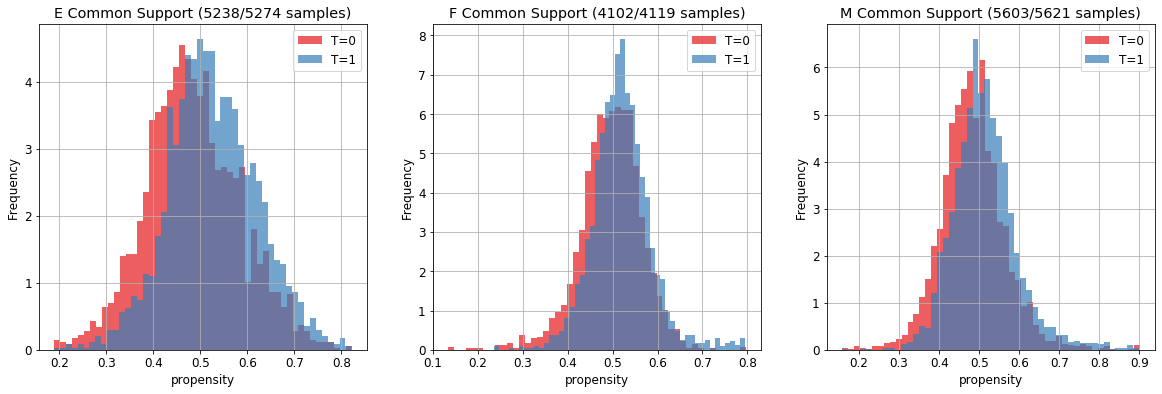

In [19]:
from proj.ci.propensity import common_support

# Select 'logistic' as the propensity method for all datasets
prop_methods = ('logistic', 'logistic', 'logistic')
cs_threshold = 5e-2 # 5%/95%

# We'll save the dataframes after removing samples outside common support
datasets_cs = {}

fig, ax = plt.subplots(nrows=1, ncols=len(datasets), figsize=(20, 6))
for i, (dataset_name, df) in enumerate(datasets.items()):
    # Copy the dataset and add a propesity column based on the selected method
    df = df.copy()
    df['propensity'] = dataset_propensities[dataset_name, prop_methods[i]]
    
    # Get common support indices and remove outlying samples
    idx_common = common_support(df['T'].to_numpy(), df['propensity'].to_numpy(),
                                min_thresh=cs_threshold, max_thresh=1-cs_threshold)
    df = df[idx_common]
    
    # Save the df with removed samples
    datasets_cs[dataset_name] = df
    
    groups = df.groupby('T')
    groups['propensity'].plot(kind='hist', sharex=True, alpha=0.7, bins=50, ax=ax[i], density=True)
    ax[i].set_xlabel('propensity'); ax[i].grid(True); ax[i].legend([f'T=0','T=1'])
    ax[i].set_title(f'{dataset_name} Common Support ({len(df)}/{len(datasets[dataset_name])} samples)')
    

In [20]:
datasets_cs['E']

X_RR  X_NN      X_AVNN      X_SDNN    X_RMSSD    X_pNN50     X_SEM  \
rec  win                                                                       
e003 1    2302  1922  785.615540  108.269882  62.563004  19.260801  2.469625   
     2    3576  2998  839.575317   85.939987  48.302204  14.848182  1.569566   
     3    4227  4211  847.497620   77.423080  23.275806   3.752969  1.193103   
     4    4135  4135  870.423950   68.379890  25.949564   4.741171  1.063385   
     5    4162  4160  864.023071   65.426506  25.984091   4.664583  1.014395   
...        ...   ...         ...         ...        ...        ...       ...   
e286 16   4840  4819  739.530396   29.074734  10.354865   0.020755  0.418830   
     17   5289  5213  666.909973   41.037853  10.034287   0.095932  0.568383   
     18   5374  5355  667.397583   23.006018  11.370922   0.261487  0.314385   
     19   4924  4856  719.261597   22.993504  10.629254   0.082389  0.329963   
     20   5130  4992  681.668823   20.523258  11.011402   0.080144  0.290475   

          X_HF_NORM  X_HF_PEAK  X_HF_POWER  ...      X_PAS  X_AGE   X_SEX  \
rec  win                                    ...                             
e003 1    14.567132   0.327401  405.839569  ...  22.320499     55    Male   
     2    19.157187   0.393928  300.040283  ...  16.210808     55    Male   
     3     3.817187   0.288532   77.754272  ...  12.134885     55    Male   
     4     6.859756   0.287784   75.483223  ...  26.457073     55    Male   
     5     7.304376   0.288532   69.686630  ...  23.221153     55    Male   
...             ...        ...         ...  ...        ...    ...     ...   
e286 16    5.571465   0.346089   11.673881  ...  15.646399     65  Female   
     17    7.548707   0.325159   10.404467  ...  15.288701     65  Female   
     18   12.584630   0.319926   12.798417  ...  18.169935     65  Female   
     19    9.975235   0.269097   13.217142  ...  14.229818     65  Female   
     20   14.472836   0.387948   13.501737  ...  16.326122     65  Female   

          Y_MSE_LO  Y_MSE_HI  Y_ALPHA1  Y_ALPHA2    Y_BETA  T  propensity  
rec  win                                                                   
e003 1    0.748595  0.861789  0.684771  1.141212  1.643589  0    0.664921  
     2    1.033521  1.156247  0.878962  1.124297  0.898494  0    0.679843  
     3    1.230048  1.417525  1.312483  1.197198  1.202459  0    0.472417  
     4    1.037712  1.159441  1.077563  1.164151  1.312657  0    0.392450  
     5    1.111461  1.274854  1.144164  1.187474  1.078064  0    0.435585  
...            ...       ...       ...       ...       ... ..         ...  
e286 16   0.585183  0.582431  1.290847  1.225419  0.832931  1    0.744449  
     17   0.896709  1.188750  1.331122  1.030012 -0.056303  1    0.628395  
     18   1.249938  1.640469  1.429094  1.105231  0.243508  1    0.495213  
     19   0.931324  1.094115  1.514911  1.133940  0.494520  1    0.606404  
     20   0.668537  0.986998  1.307981  1.334617  1.341095  1    0.635375  

[5238 rows x 32 columns]

## Part 4: S-Learner

An S-Learner is a model which predicts the outcome given both the covariates and treatment assignemnt:
$
\hat y = f(\vec{x},t).
$
We will train a supervised regression model and then we can estimate the ATE with an inductive approach, as
$$
\widehat{\mathrm{ATE}}_{SL} =
\frac{1}{\left|\cset{T}\right|} \sum_{i\in\cset{T}} y_i-f(\vec{x}_i,0)
+
\frac{1}{\left|\cset{C}\right|} \sum_{i\in\cset{C}} f(\vec{x}_i, 1)-y_i
$$
where $\cset{T} := \setof{i \given t_i = 1}$ and $\cset{C} := \setof{i \given t_i = 0}$ are the treated group and control groups respectively.

We fit four types of models to the data and apply a randomized Cross Validation to select the best parameters for each model and then the best type of model. We test regular linear regression models with L2 regularization (Ridge),
L1 regularization (Lasso), a Gradient Boosting Machine (GBM) and a multilayer perceptron (MLP).

In [21]:
from proj.ci.cv import CVConfig, MLPHiddenLayerSampler, LogSpaceSampler

# Define model types and parameters samplers for the Cross Validation
import scipy.stats as stats
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import RegressorChain

rcv_config = dict(
    ridge=CVConfig(
        model=Ridge(),
        params=dict(alpha=LogSpaceSampler(-2, 1))
    ),
    
    lasso=CVConfig(
        model=Lasso(max_iter=2000,tol=0.001),
        params=dict(alpha=LogSpaceSampler(-2, 1))),
    
    gbm=CVConfig(
        model=RegressorChain(GradientBoostingRegressor()),
        params=dict(
            base_estimator__n_estimators=stats.randint(1, 100+1),
            base_estimator__max_depth=stats.randint(1, 5+1),
            base_estimator__learning_rate=LogSpaceSampler(-2, 0.5),
        )),
    
#     mlp=CVConfig(
#         model=MLPRegressor(solver='lbfgs', max_iter=300),
#         params=dict(
#             hidden_layer_sizes=MLPHiddenLayerSampler(4, 200),
#             activation=['logistic', 'tanh', 'relu'],
#             alpha=LogSpaceSampler(-2, 1),
#         )),
)

Now we'll fit all four models types to the data and use Cross Validation to find good parameters for each.
The Cross Validation first sets appart 30% of the data as a test test with stratification on $t$.
Then, for each parameter configuration the training set is split further into four folds, again stratified on $t$,
and each time one fold is used as a validation set while the model is fit on the remaining three. We select the best parameters for each model based on average
$R^2$ score on the validation sets for that parameter configuration.

This procedure is implemented by the `fit_slearner_cv` function in the `models.py` module.

In [22]:
from proj.ci.models import fit_slearner_cv

# Create a dataframe to store the CV results
df_cv_slearner = pd.DataFrame(
    index=pd.MultiIndex.from_product([datasets_cs.keys(), rcv_config.keys()]),
    columns=('train', 'test', 'cv_model')
)

# Run each CV configuration
for i, (dataset_name, df) in enumerate(datasets_cs.items()):
    X, y, t = data.split_dataset(df, scale_covariates=True)
    
    for model_name, cv_cfg in rcv_config.items():
        
        model, train_score, test_score = fit_slearner_cv(
            cv_cfg, X, y, t, random_state=42042+i,
            interaction=True, test_size=0.1, cv_splits=3, n_iter=16
        )
    
        df_cv_slearner.loc[(dataset_name, model_name), :] = [train_score, test_score, model]
        print(f'{dataset_name}\tmodel={model_name}\tbest_params={model.best_params_}')

df_cv_slearner[['train', 'test']]

E	model=ridge	best_params={'model__alpha': 0.40475503376854377}
E	model=lasso	best_params={'model__alpha': 0.018449125250586642}
E	model=gbm	best_params={'model__base_estimator__learning_rate': 0.2624233570287428, 'model__base_estimator__max_depth': 4, 'model__base_estimator__n_estimators': 85}
F	model=ridge	best_params={'model__alpha': 4.123622641801824}
F	model=lasso	best_params={'model__alpha': 0.011580858219273479}
F	model=gbm	best_params={'model__base_estimator__learning_rate': 0.28011956494445395, 'model__base_estimator__max_depth': 4, 'model__base_estimator__n_estimators': 22}
M	model=ridge	best_params={'model__alpha': 0.11909430191806088}
M	model=lasso	best_params={'model__alpha': 0.010009541781720857}
M	model=gbm	best_params={'model__base_estimator__learning_rate': 0.11985730301355615, 'model__base_estimator__max_depth': 5, 'model__base_estimator__n_estimators': 58}


train      test
E ridge  0.427945  0.421971
  lasso  0.292827  0.285979
  gbm    0.732915  0.440836
F ridge  0.449859  0.468781
  lasso  0.375023  0.396377
  gbm     0.58403  0.455237
M ridge  0.418155  0.422813
  lasso  0.349584   0.38377
  gbm    0.645756  0.472729

The table above shows the $R^2$ score of the different models on the train set (70% of the data) and test set (30%).
We can see that the non-linear models (GBM and MLP) produce much better results than the linear models (Ridge and Lasso),
with relatively minimal overfitting. We will select the best S-Learner model for each dataset based on the test-set score.

We now use the best model to estimate the ATT in each dataset.
In addition, we use the previously-calculated propensity scores $\hat e(\vec{x})$ to obtain a doubly-robust (DR) estimator,
in the following way:

$$
\begin{align}
\widehat{\mathrm{ATE}}_{SLDR}
&= 
\frac{1}{\left|\cset{D}\right|} \sum_{i\in\cset{D}}
\left[
    \frac{t_i y_i}{\hat e(\vec{x}_i)} - \frac{t_i - \hat e(\vec{x}_i)}{\hat e(\vec{x}_i)}\cdot f(\vec{x}_i, 1)
\right]
-
\frac{1}{\left|\cset{D}\right|} \sum_{i\in\cset{D}}
\left[
    \frac{(1-t_i)y_i}{1-\hat e(\vec{x}_i)} + \frac{t_i-\hat e(\vec{x}_i)}{1-\hat e(\vec{x}_i)}\cdot f(\vec{x}_i, 0)
\right] \\
&=
\frac{1}{\left|\cset{D}\right|} \sum_{i\in\cset{D}}
\left[
    f(\vec{x}_i, 1) - \frac{t_i}{\hat e(\vec{x}_i)} \cdot \left( f(\vec{x}_i, 1) - y_i\right)
\right]
-
\frac{1}{\left|\cset{D}\right|} \sum_{i\in\cset{D}}
\left[
    f(\vec{x}_i, 0) - \frac{1-t_i}{1-\hat e(\vec{x}_i)} \cdot \left( f(\vec{x}_i, 0) - y_i\right)
\right].
\end{align}
$$

Where $\cset{D}:=\cset{T}\cup\cset{C}$ is the full dataset.
This method takes the estimation error $\hat{y}_i - y_i$ into account and weighs it according to the inverse
propensity. It was shown to produce unbiased estimations of the treatment effect even if only one of the models (propensity or outcome regressor) is unbiased.

The S-Learner ATT estimation based on the best model is implemented in the `s_learner` function within the `att.py` module.

In [49]:
from proj.ci import treatment_effect

# Estimate ATE with S-Learner, using best fitted model for each dataset.
df_ate_slearner = pd.DataFrame(index=list(datasets_cs.keys()), columns=outcome_columns)
model_selection = 'test'

for i, (name, df) in enumerate(datasets_cs.items()):
    # Get data
    X, y, t = data.split_dataset(df, scale_covariates=True)
    p = df['propensity'].values
    
    # Get best model based on test-set score on the current dataset
    model_name = df_cv_slearner.loc[name, model_selection].astype(float).idxmax() 
    model = df_cv_slearner.loc[(name, model_name), 'cv_model']
    print(f'{name}: estimating with {model_name}{model.best_params_}')
    
    est_ate = treatment_effect.s_learner(model, X, y, t, propensity=p, interaction=True, transductive=False)
    df_ate_slearner.loc[name, :] = est_ate
    
df_ate_slearner

E: estimating with gbm{'model__base_estimator__learning_rate': 0.2624233570287428, 'model__base_estimator__max_depth': 4, 'model__base_estimator__n_estimators': 85}
F: estimating with ridge{'model__alpha': 4.123622641801824}
M: estimating with gbm{'model__base_estimator__learning_rate': 0.11985730301355615, 'model__base_estimator__max_depth': 5, 'model__base_estimator__n_estimators': 58}


,Y_MSE_LO,Y_MSE_HI,Y_ALPHA1,Y_ALPHA2,Y_BETA
E,-0.0389681,-0.0489107,-0.0493406,0.0224602,0.0672458
F,-0.06326,-0.0944073,-0.0838292,0.0116299,0.0945344
M,-0.0242016,-0.011167,-0.0191181,0.014678,0.0235464


## Part 4: T-Learner

The T-Learner formulation consists of fitting two different model which predict the outcome $\rvar{Y}$ given the covariates $\rvec{X}$ alone.

The first model,
$\hat y_1 = f_1(\vec{x})$, is fitted on the treated group, and the second model, $\hat y_0 = f_0(\vec{x})$,
is fitted on the control group.

Then we can estimate the ATE (with an inductive approach) as
$$
\widehat{\mathrm{ATE}}_{TL} =
\frac{1}{\left|\cset{T}\right|} \sum_{i\in\cset{T}} y_i-f_0(\vec{x}_i)
+
\frac{1}{\left|\cset{C}\right|} \sum_{i\in\cset{C}} f_1(\vec{x}_i)-y_i
$$
In other words, these models are used for estimating the counterfactual outcome when used for inference
on a data point belonging the group they weren't fitted on.


We'll fit the same types of models using the same CV scheme as for the S-Learner, but now we'll split each dataset into the treatment and control groups before fitting.
This will give us a best estimator per dataset and per group.

In [27]:
group_names = ('Treated', 'Control')

# Create a dataframe to store the CV results
df_cv_tlearner = pd.DataFrame(
    index=pd.MultiIndex.from_product([datasets_cs.keys(), rcv_config.keys()]),
    columns=pd.MultiIndex.from_product([group_names, ['train', 'test', 'cv_model']])
)


In [29]:
# Run each CV configuration
for i, (name, df) in enumerate(datasets_cs.items()):
    X, y, t = data.split_dataset(df, scale_covariates=True)
    idx_treat = t == 1
    
    for model_name, cv_cfg in rcv_config.items():
        
        # Apply CV-based fitting in each group
        for k, idx in enumerate((idx_treat, ~idx_treat)):
            
            common_args = dict(random_state=42042+i+k, interaction=None,
                               test_size=0.3, cv_splits=3, n_iter=42)
            
            model, train_score, test_score = fit_slearner_cv(
                cv_cfg, X[idx], y[idx], t[idx], **common_args
            )
            
            df_cv_tlearner.loc[(name, model_name), group_names[k]] = [
                train_score, test_score, model
            ]
        
            print(f'{name}-{group_names[k]}\tmodel={model_name}\tbest_params={model.best_params_}')

df_cv_tlearner.loc[:, pd.IndexSlice[:, ('train', 'test')]]

E-Treated	model=ridge	best_params={'model__alpha': 9.771120359676154}
E-Control	model=ridge	best_params={'model__alpha': 0.06677077102062737}
E-Treated	model=lasso	best_params={'model__alpha': 0.014446101918418802}
E-Control	model=lasso	best_params={'model__alpha': 0.011580858219273479}
E-Treated	model=gbm	best_params={'model__base_estimator__learning_rate': 0.1444436000657983, 'model__base_estimator__max_depth': 4, 'model__base_estimator__n_estimators': 80}
E-Control	model=gbm	best_params={'model__base_estimator__learning_rate': 0.2622626061639907, 'model__base_estimator__max_depth': 5, 'model__base_estimator__n_estimators': 26}
F-Treated	model=ridge	best_params={'model__alpha': 9.921186780120127}
F-Control	model=ridge	best_params={'model__alpha': 0.011032969035440711}
F-Treated	model=lasso	best_params={'model__alpha': 0.011580858219273479}
F-Control	model=lasso	best_params={'model__alpha': 0.010009541781720857}
F-Treated	model=gbm	best_params={'model__base_estimator__learning_rate': 

Treated             Control          
            train      test     train      test
E ridge  0.156437  0.111543  0.712683   0.71275
  lasso  0.126562  0.102584  0.654946  0.659149
  gbm    0.533272  0.151363   0.91485   0.76506
F ridge  0.184355  0.169789  0.717077  0.731903
  lasso  0.156378   0.14807  0.681877  0.707798
  gbm    0.420412  0.182268  0.947126  0.784555
M ridge  0.141834  0.152511  0.716178  0.673971
  lasso  0.117153  0.124741  0.659695  0.626654
  gbm    0.379342  0.226853  0.933939  0.765343

The table above shows the $R^2$ score of the different models on the train set (70% of the data) and test set (30%).
As before, the non-linear models produce much better results than the linear models,
and specifically the GBM seems to perform best in all cases.
We will select the best model separately for each group and dataset based on the test-set score, so in total we'll have four best-fitted regression models.

We now use the best models to estimate the ATT in each dataset.
We'll again use the propensity scores $\hat e(\vec{x})$ to obtain a doubly-robust (DR) estimator,
but this time it uses a different model in each group:

$$
\widehat{\mathrm{ATE}}_{TLDR}
= 
\frac{1}{\left|\cset{D}\right|} \sum_{i\in\cset{D}}
\left[
    \frac{t_i y_i}{\hat e(\vec{x}_i)} - \frac{t_i - \hat e(\vec{x}_i)}{\hat e(\vec{x}_i)}\cdot f_1(\vec{x}_i)
\right]
-
\frac{1}{\left|\cset{D}\right|} \sum_{i\in\cset{D}}
\left[
    \frac{(1-t_i)y_i}{1-\hat e(\vec{x}_i)} + \frac{t_i-\hat e(\vec{x}_i)}{1-\hat e(\vec{x}_i)}\cdot f_0(\vec{x}_i)
\right].
$$

The T-Learner ATT estimation based on the best models is implemented in the `t_learner` function within the `treatment_effect.py` module.

In [52]:
# Estimate ATT with T-Learner, using best fitted model for each dataset and group.
df_ate_tlearner = pd.DataFrame(index=datasets_cs.keys(), columns=outcome_columns)
model_selection = 'test'

for i, (name, df) in enumerate(datasets_cs.items()):
    # Get data
    X, y, t = data.split_dataset(df, scale_covariates=True)
    p = df['propensity'].values
    
    # Loop over treatment/control groups and get the best model
    best_models = {}
    for group_name in group_names:
        
        # Get index of best model based on test-set score on the current dataset and group
        imax = df_cv_tlearner.loc[pd.IndexSlice[name,:],
                                  pd.IndexSlice[group_name, model_selection]].astype(float).idxmax()
        
        # Save best model for this group
        model_name = imax[-1]
        model = df_cv_tlearner.loc[imax,(group_name, 'cv_model')]
        best_models[group_name] = model
        
        print(f'{name}-{group_name}: estimating with {model_name}{model.best_params_}')

    # Estimate the ATE using the two best models for this dataset
    est_att = treatment_effect.t_learner(
        best_models[group_names[0]], best_models[group_names[1]],
        X, y, t, propensity=p
    )
    df_ate_tlearner.loc[name, :] = est_att
    
df_ate_tlearner

E-Treated: estimating with gbm{'model__base_estimator__learning_rate': 0.1444436000657983, 'model__base_estimator__max_depth': 4, 'model__base_estimator__n_estimators': 80}
E-Control: estimating with gbm{'model__base_estimator__learning_rate': 0.2622626061639907, 'model__base_estimator__max_depth': 5, 'model__base_estimator__n_estimators': 26}
F-Treated: estimating with gbm{'model__base_estimator__learning_rate': 0.11060303210018947, 'model__base_estimator__max_depth': 4, 'model__base_estimator__n_estimators': 51}
F-Control: estimating with gbm{'model__base_estimator__learning_rate': 0.1915374676678216, 'model__base_estimator__max_depth': 4, 'model__base_estimator__n_estimators': 87}
M-Treated: estimating with gbm{'model__base_estimator__learning_rate': 0.07289520774939232, 'model__base_estimator__max_depth': 4, 'model__base_estimator__n_estimators': 82}
M-Control: estimating with gbm{'model__base_estimator__learning_rate': 0.0918374561947457, 'model__base_estimator__max_depth': 5, 'mo

,Y_MSE_LO,Y_MSE_HI,Y_ALPHA1,Y_ALPHA2,Y_BETA
E,-0.0403099,-0.0392222,-0.0505233,0.0225301,0.0851216
F,-0.0621205,-0.0888962,-0.0870239,0.0247369,0.120101
M,-0.0230432,-0.0111992,-0.0195838,0.0145932,0.0327351


In [55]:
df_ate.transpose()

Y_MSE_LO   Y_MSE_HI   Y_ALPHA1   Y_ALPHA2     Y_BETA
E $\widehat{ATE}$  -0.066868  -0.089082  -0.061461   0.022654   0.090614
  $ATE$            -0.056554  -0.071586  -0.050009   0.013562   0.055224
  % Error          18.236618  24.440081  22.899115  67.038033  64.083611
F $\widehat{ATE}$  -0.081451  -0.105161  -0.109631   0.025450   0.109738
  $ATE$            -0.071134  -0.101154  -0.085708   0.019561   0.089532
  % Error          14.504017   3.961892  27.911373  30.110556  22.568552
M $\widehat{ATE}$  -0.005978  -0.008209  -0.004685   0.029245   0.016654
  $ATE$            -0.033982  -0.033310  -0.026287   0.016485   0.031466
  % Error          82.407394  75.356964  82.178307  77.398560  47.073940